In [28]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
%pylab inline
import json

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [43]:
import itertools
import random
import pandas as pd
from math import radians, cos, sin, asin, sqrt

In [37]:
zipcodedistance = pd.read_csv("ZipcodeDistance.csv")

In [39]:
zipcodedistance.head()

,Zip,Latitude,Longitude
0,10001,40.750634,-73.997176
1,10002,40.715777,-73.986207
2,10003,40.731829,-73.989181
3,10004,40.694179,-74.015966
4,10005,40.706004,-74.008785


In [44]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    meters = 6373 * 1000 * c
    return meters

In [66]:
cbikelist = [10001, 10002, 10003, 10004, 10005, 10007, 10009, 10010, 10011, 10012, 
             10013, 10014, 10016, 10017, 10018, 10019, 10021, 10022, 10023, 10024,
             10028, 10036, 10038, 10065, 10075, 10280, 10281, 10282, 11101, 11201,
             11205, 11206, 11211, 11216, 11217, 11220, 11221, 11222, 11233, 11238, 
             11251]
dist_dict = {}
for subset in itertools.product(cbikelist,cbikelist):
    lon1 = zipcodedistance['Longitude'][zipcodedistance['Zip'] == subset[0]]
    lat1 = zipcodedistance['Latitude'][zipcodedistance['Zip'] == subset[0]]
    lon2 = zipcodedistance['Longitude'][zipcodedistance['Zip'] == subset[1]]
    lat2 = zipcodedistance['Latitude'][zipcodedistance['Zip'] == subset[1]]
    dist_dict[str(subset[0])+str(subset[1])] = haversine(lon1, lat1, lon2, lat2)

In [67]:
f = open('./results/results_TotalJanMaySept', 'r')
pairs = f.read().split("\n")

dict_total = {}
zip_pair_pre = None
cnt = 0
tm_list = []
mode_list = []
for item in pairs[:-1]:
    print(item)
    trip, av_time, count = item.split("\t") #  
    zip_pair, mode = trip.split("|")
    zip_origin, zip_destin = zip_pair[:5], zip_pair[5:]
    if zip_pair == zip_pair_pre:
        cnt += 1
    else:
        if cnt == 2 and len(set(mode_list))==2:
            # Taxis - Citi bike
            #dict_total[zip_pair_pre] = [100*((float(tm_list[-2:][1]) - float(tm_list[-2:][0]) )/ float(tm_list[-2:][1])), dist_dict[zip_pair_pre] ]
            # Structure of the dictionay values: difference (taxis - bikes), distance, Citi Bike time, Taxi time.            
            dict_total[zip_pair_pre] = [float(tm_list[-2:][1]) - float(tm_list[-2:][0]) , dist_dict[zip_pair_pre] ,float(tm_list[-2:][0]) ,float(tm_list[-2:][1])]
            print("Si")
            tm_list = []
            mode_list = []
        cnt=1
    zip_pair_pre = zip_pair
    tm_list.append(av_time)
    mode_list.append(mode)

0008310001|citibike	1939 	 35
0008310002|citibike	951 	 13
0008310003|citibike	1989 	 2
0008310005|citibike	1346 	 6
0008310009|citibike	287 	 1
0008310010|citibike	1247 	 6
0008310011|citibike	983 	 6
0008310013|citibike	1368 	 4
0008310014|citibike	1813 	 3
0008310016|citibike	1559 	 4
0008310017|citibike	948 	 20
0008310018|citibike	763 	 15
0008310019|citibike	799 	 14
0008310022|citibike	815 	 66
0008310023|citibike	697 	 48
0008310036|citibike	708 	 31
0008311211|citibike	707 	 16
1000100083|citibike	1658 	 1
1000110001|citibike	2130 	 23
1000110001|taxis	371 	 4451
1000110002|citibike	446 	 170486
Si
1000110002|taxis	1556 	 238
1000110003|citibike	1224 	 35978
Si
1000110003|taxis	749 	 1826
1000110004|citibike	722 	 129783
Si
1000110004|taxis	1687 	 114
1000110005|citibike	1353 	 11654
Si
1000110005|taxis	1761 	 53
1000110007|citibike	1294 	 9754
Si
1000110007|taxis	1420 	 156
1000110009|citibike	1068 	 23251
Si
1000110009|taxis	1044 	 497
1000110010|citibike	949 	 42451
Si
1000

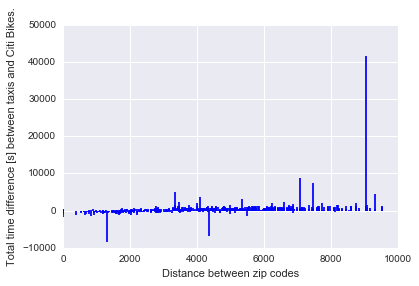

In [68]:
plt.vlines([val[1] for val in dict_total.values()], [0],[val[0] for val in dict_total.values()],color='blue')
plt.xlabel("Distance between zip codes")
plt.ylabel("Total time difference [s] between taxis and Citi Bikes.")

In [50]:
Total_trips = pd.DataFrame({"Citi Bike": [val[2] for val in dict_total.values()], 
                            "Taxi":[val[3] for val in dict_total.values()]},columns=["Citi Bike","Taxi"])

In [51]:
print "Mean for Citi bike: "+str(np.mean([val[2] for val in dict_total.values()]))
print "Mean for Taxis: " +str(np.mean([val[3] for val in dict_total.values()]))

Mean for Citi bike: 1091.2
Mean for Taxis: 1386.74567901


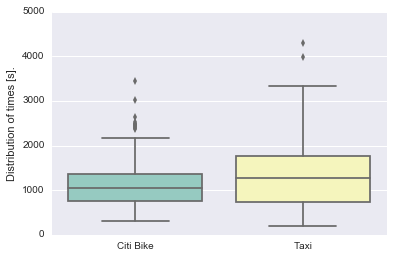

In [69]:
ax = sns.boxplot(Total_trips,palette="Set3")
ax.set_ylim(0,5000)
ax.set( ylabel= "Distribution of times [s].")

In [53]:
#Crete pairs for weekday rush vs. non-rush scenarios.
f = open('./results/results_RushJanMaySept', 'r')
pairs = f.read().split("\n")

dict_rush = {}
zip_pair_pre = None
cnt = 0
tm_list = []
mode_list = []
for item in pairs[:-1]:
    print(item)
    trip, av_time, count = item.split("\t") #  
    zip_pair, form = trip.split("|")
    mode, rush = form.split("&")
    zip_origin, zip_destin = zip_pair[:5], zip_pair[5:]
    if zip_pair == zip_pair_pre:
        cnt += 1
    else:
        if cnt == 4 and len(set(mode_list))==2:
            # citibike&rush, citibike&valley, taxis&rush, taxis&valley 
            # Taxi - Citi bike rush, Taxi - Citi Bike non rush
            dict_rush[zip_pair_pre] = [['rush','valley'],  float(tm_list[-4:][2]) - float(tm_list[-4:][0]),float(tm_list[-4:][3]) - float(tm_list[-4:][1])  , dist_dict[zip_pair_pre]] #100*((float(tm_list[-2:][1]) - float(tm_list[-2:][0]) )/ float(tm_list[-2:][1])) 
            print("Si")
            tm_list = []
            mode_list = []
        cnt=1
    zip_pair_pre = zip_pair
    tm_list.append(av_time)
    mode_list.append(mode)

0008300083|citibike&valley	1934 	 5
0008310001|citibike&rush	1554 	 7
0008310001|citibike&valley	1234 	 4
0008310003|citibike&rush	852 	 7
0008310003|citibike&valley	1260 	 1
0008310005|citibike&valley	1256 	 2
0008310009|citibike&rush	287 	 1
0008310011|citibike&rush	1237 	 5
0008310011|citibike&valley	1414 	 2
0008310013|citibike&valley	1596 	 1
0008310014|citibike&valley	1698 	 1
0008310016|citibike&rush	1348 	 1
0008310016|citibike&valley	738 	 4
0008310017|citibike&rush	1025 	 5
0008310017|citibike&valley	758 	 1
0008310018|citibike&valley	709 	 4
0008310019|citibike&rush	809 	 8
0008310019|citibike&valley	548 	 9
0008310022|citibike&rush	671 	 21
0008310022|citibike&valley	498 	 10
0008310023|citibike&rush	691 	 14
0008310023|citibike&valley	231 	 3
0008310036|citibike&rush	516 	 15
0008310036|citibike&valley	745 	 4
0008311211|citibike&rush	641 	 5
1000100083|citibike&rush	1658 	 1
1000100083|citibike&valley	1251 	 7
1000110001|citibike&rush	3833 	 8
1000110001|citibike&valley	3

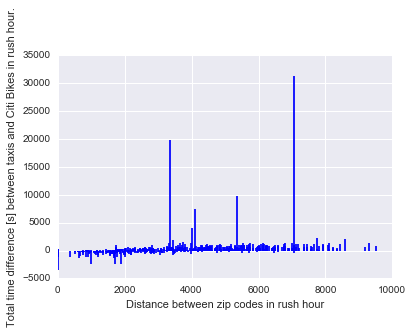

In [54]:
plt.vlines([val[3] for val in dict_rush.values()], [0],[val[1] for val in dict_rush.values()],color='blue')
plt.xlabel("Distance between zip codes in rush hour")
plt.ylabel("Total time difference [s] between taxis and Citi Bikes in rush hour.")

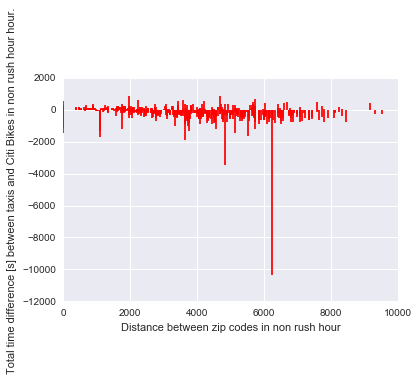

In [55]:
plt.vlines([val[3] for val in dict_rush.values()], [0],[val[2] for val in dict_rush.values()],color='red')
plt.xlabel("Distance between zip codes in non rush hour")
plt.ylabel("Total time difference [s] between taxis and Citi Bikes in non rush hour hour.")

In [56]:
print "Mean difference in rush hour: "+str(np.mean([val[1] for val in dict_rush.values()]))
print "Mean difference in non rush hour: " +str(np.mean([val[2] for val in dict_rush.values()]))

Mean difference in rush hour: 253.708933718
Mean difference in non rush hour: -154.808357349


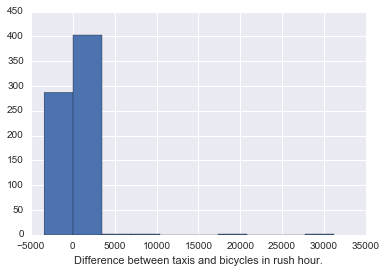

In [57]:
plt.hist([val[1] for val in dict_rush.values()])
plt.xlabel("Difference between taxis and bicycles in rush hour.")

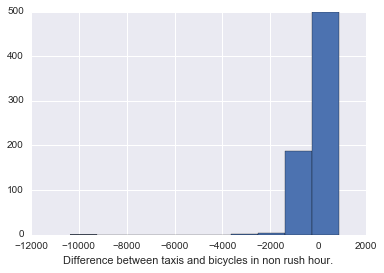

In [58]:
plt.hist([val[2] for val in dict_rush.values()])
plt.xlabel("Difference between taxis and bicycles in non rush hour.")

In [59]:
#Create pairs for weekend day vs-night scenarios.
f = open('./results/results_SaturdayJanMaySept', 'r')
pairs = f.read().split("\n")

dict_weekend = {}
zip_pair_pre = None
cnt = 0
tm_list = []
mode_list = []
for item in pairs[:-1]:
    print(item)
    trip, av_time, count = item.split("\t") #  
    zip_pair, form = trip.split("|")
    mode, rush = form.split("&")
    zip_origin, zip_destin = zip_pair[:5], zip_pair[5:]
    if zip_pair == zip_pair_pre:
        cnt += 1
    else:
        if cnt == 4 and len(set(mode_list))==2:
            # citibike&day, citibike&night, taxis&day, taxis&night  
            dict_weekend[zip_pair_pre] = [['day','night'],  float(tm_list[-4:][2]) - float(tm_list[-4:][0]) ,float(tm_list[-4:][3]) - float(tm_list[-4:][1]), dist_dict[zip_pair_pre] ] #100*((float(tm_list[-2:][1]) - float(tm_list[-2:][0]) )/ float(tm_list[-2:][1])) 
            print("Si")
            tm_list = []
            mode_list = []
        cnt=1
    zip_pair_pre = zip_pair
    tm_list.append(av_time)
    mode_list.append(mode)

0008310016|citibike&night	2233 	 1
0008310019|citibike&night	810 	 1
1000110001|citibike&day	952 	 3
1000110001|citibike&night	309 	 5
1000110001|taxis&day	293 	 70
1000110001|taxis&night	414 	 16567
1000110002|citibike&night	443 	 7170
Si
1000110002|taxis&day	1536 	 3
1000110002|taxis&night	1224 	 3331
1000110003|citibike&day	1415 	 2985
1000110003|citibike&night	446 	 2
1000110003|taxis&day	751 	 25
1000110003|taxis&night	761 	 11495
1000110004|citibike&night	848 	 8260
Si
1000110004|taxis&day	1828 	 1
1000110004|taxis&night	1165 	 1200
1000110005|taxis&day	1137 	 327
1000110005|taxis&night	1208 	 578
1000110007|taxis&day	1135 	 359
1000110007|taxis&night	1056 	 1775
1000110009|citibike&night	1101 	 532
1000110009|taxis&day	1031 	 6
1000110009|taxis&night	983 	 3245
1000110010|citibike&day	1141 	 3085
1000110010|citibike&night	385 	 1
1000110010|taxis&day	324 	 10
1000110010|taxis&night	525 	 7163
1000110011|citibike&day	547 	 4171
Si
1000110011|citibike&night	417 	 1
1000110011|taxi

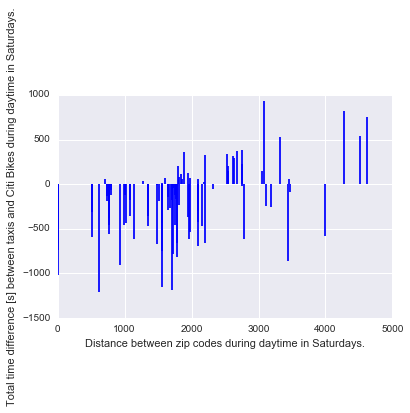

In [60]:
plt.vlines([val[3] for val in dict_weekend.values()], [0],[val[1] for val in dict_weekend.values()],color='blue')
plt.xlabel("Distance between zip codes during daytime in Saturdays.")
plt.ylabel("Total time difference [s] between taxis and Citi Bikes during daytime in Saturdays.")

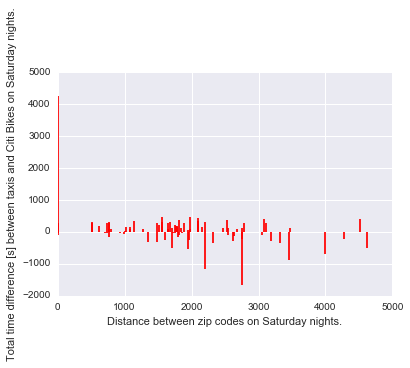

In [61]:
plt.vlines([val[3] for val in dict_weekend.values()], [0],[val[2] for val in dict_weekend.values()],color='red')
plt.xlabel("Distance between zip codes on Saturday nights.")
plt.ylabel("Total time difference [s] between taxis and Citi Bikes on Saturday nights.")

In [62]:
print "Mean difference on Saturday daytime: "+str(np.mean([val[1] for val in dict_weekend.values()]))
print "Mean difference on Saturday night: " +str(np.mean([val[2] for val in dict_weekend.values()]))

Mean difference on Saturday daytime: -215.936842105
Mean difference on Saturday night: 65.8421052632


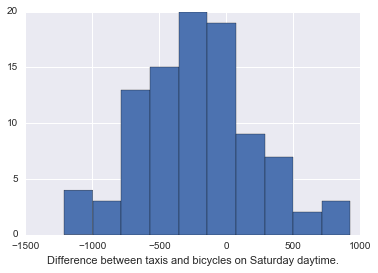

In [63]:
plt.hist([val[1] for val in dict_weekend.values()])
plt.xlabel("Difference between taxis and bicycles on Saturday daytime.")

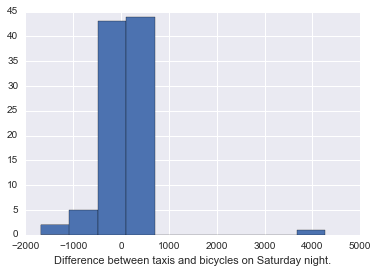

In [64]:
plt.hist([val[2] for val in dict_weekend.values()])
plt.xlabel("Difference between taxis and bicycles on Saturday night.")

In [65]:
# # -- Save dictionaries in json files  
  

# with open('./results/total_trips.json', 'w') as fp:
#     json.dump(dict_total, fp)
    
# with open('./results/rush_nonrush.json', 'w') as fp:
#     json.dump(dict_rush, fp)

# with open('./results/total_weekends.json', 'w') as fp:
#     json.dump(dict_weekend, fp)  